<a href="https://colab.research.google.com/github/maryamhashemi/Persian_VQA/blob/master/pvqa_BilstmQ_resNet152(last_soft).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Prerequesties

In [ ]:
# !pip install arabic_reshaper 
# !pip install python-bidi
# !pip install deepdish
# !pip install h5py
# !pip install --upgrade numpy
# !pip install --upgrade tables
!pip install hazm
!pip install h5py


     |████████████████████████████████| 317kB 4.7MB/s 
     |████████████████████████████████| 1.4MB 14.9MB/s 
     |████████████████████████████████| 235kB 36.5MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394470 sha256=c9641132a46fec01b3b930374247dd89df4e19a7f0a90dce644c81d4de7fed1f
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=155249 sha256=63ec357de0143ce7c6f953fc5f9f04777301fbfaf600c77473d67f014a3927fb
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built nltk libwapiti
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import h5py
import os
import re
import json
import numpy as np
# import deepdish as dd
from PIL import Image
# import arabic_reshaper
from collections import Counter
import matplotlib.pyplot as plt
# from bidi.algorithm import get_display
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Multiply, Input,BatchNormalization

import random as python_random
import tensorflow as tf
import math
from tensorflow.keras.callbacks import EarlyStopping 
import tensorflow as tf
import hazm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Set Parameters

In [ ]:
DROPOUT_RATE = 0.5
EMBEDDING_DIM = 300
EPOCHS = 10
BATCH_SIZE = 256
SEQ_LENGTH = 26 #100
VOCAB_SIZE = 1000
OOV_TOK = "<OOV>"

BASE_PATH = '/content/drive/My Drive/Persian_VQA/dataset/'
QUESTION_TRAIN_PATH =   os.path.join(BASE_PATH, 'google-train_questions.json')#OpenEnded_mscoco_train2014_questions.json
ANNOTATION_TRAIN_PATH = os.path.join(BASE_PATH, 'mscoco_train2014_annotations.json')
# IMAGE_TRAIN_PATH = os.path.join(BASE_PATH, 'train_images_1000')
IMAGE_TRAIN_PATH = os.path.join('/content/', 'train')

QUESTION_VAL_PATH =   os.path.join(BASE_PATH, 'google-val_questions.json')#'OpenEnded_mscoco_val2014_questions.json'
ANNOTATION_VAL_PATH = os.path.join(BASE_PATH, 'mscoco_val2014_annotations.json')
# IMAGE_VAL_PATH = os.path.join(BASE_PATH, 'val_images_500')
IMAGE_VAL_PATH = os.path.join('/content/', 'val')

QUESTION_TEST_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_TEST_PATH = os.path.join(BASE_PATH, '...')
# IMAGE_TEST_PATH = os.path.join(BASE_PATH, 'val_images_500')
IMAGE_TEST_PATH = os.path.join('/content/', 'test')

NUM_OF_CLASSES=1000
NUM_OF_MOST_COMMON_ANSWERS = 1000#999
BASE_PATH_parssoft = '/content/drive/My Drive/parssoftco_PVQA/'
BASE_PATH_parssoft2 = '/content/drive/My Drive/parssoftco_PVQA2/'
BASE_PATH_parssoft3 = '/content/drive/My Drive/parssoftco_PVQA3/'
BASE_PATH_parssoft4 = '/content/drive/My Drive/parssoftco_PVQA4/'
BASE_PATH_parssoft5 = '/content/drive/My Drive/parssoftco_PVQA5/'
BASE_PATH_parssoft6 = '/content/drive/My Drive/parssoftco_PVQA6/'

In [ ]:
# import os
from zipfile import ZipFile
# #If the downloaded file is a zip file than you can use below function to unzip it.
def unzip(dir,where):
    with ZipFile(dir) as zipf:
        zipf.extractall(where)
    print("File Unzipped!")

### Read Data

In [ ]:
def most_common_answer_from_train(answers,num_of_common_answers):
  counts = {}
  for ans in answers:
      counts[ans] = counts.get(ans,0) + 1
  counter = sorted([(count,w) for w,count in counts.items()], reverse=True)
  most_common_vocab = []
  for i in range(num_of_common_answers):
      most_common_vocab.append(counter[i][1])
  return most_common_vocab#,counts

In [ ]:
def create_train_dataset(qus, ann, answertoindex):
  qs = []
  # raw_answers = []
  answers = []
  qs_id = []
  im_id = []

  # ann2=ann
  # for ann in ann['annotations']:
  #   raw_answers.append(ann['multiple_choice_answer'])
  # most_common_answers = most_common_answer_from_train(raw_answers,NUM_OF_MOST_COMMON_ANSWERS)
  # answertoindex = {w:i+1 for i,w in enumerate(most_common_answers)}
  # indextoanswer = {i+1:w for i,w in enumerate(most_common_answers)}

  filtered_train_question_ids={}
  # ann=ann2





  i=0
  for ann in ann['annotations']:
 
    if ann['multiple_choice_answer'] in answertoindex.keys():
      answers.append(ann['multiple_choice_answer'])
      # filtered_train_question_ids.append(ann['question_id'])
      filtered_train_question_ids[ann['question_id']]=1
      # if(i%1000==0):print(i)
      i+=1

  for q in qus['questions']:
    if q['question_id'] in filtered_train_question_ids.keys():
      qs.append(q['question'])
      qs_id.append(q['question_id'])
      im_id.append(q['image_id'])


  return qs, answers, qs_id, im_id

In [ ]:
def create_dataset(qus, ann):
  qs = []
  raw_answers = []
  answers = []
  qs_id = []
  im_id = []
 

  for q in qus['questions']:
    qs.append(q['question'])
    qs_id.append(q['question_id'])
    im_id.append(q['image_id'])

  for ann in ann['annotations']:
    answers.append(ann['multiple_choice_answer'])


  return qs, answers, qs_id, im_id

In [ ]:
def get_train_dataset():
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))

  original_ann = ann
  raw_answers = []
  for ann in ann['annotations']:
    raw_answers.append(ann['multiple_choice_answer'])
  most_common_answers = most_common_answer_from_train(raw_answers,NUM_OF_MOST_COMMON_ANSWERS)#NUM_OF_MOST_COMMON_ANSWERS
  answertoindex = {w:i for i,w in enumerate(most_common_answers)}#i+1
  indextoanswer = {i:w for i,w in enumerate(most_common_answers)}#i+1

  qs, answers, qs_id, im_id=create_train_dataset(qs, original_ann, answertoindex)

  return qs, answers, qs_id, im_id,answertoindex,indextoanswer

In [ ]:
def get_val_dataset():
  qs = json.load( open(QUESTION_VAL_PATH))
  ann = json.load( open(ANNOTATION_VAL_PATH))
  
  return create_dataset(qs, ann)

In [ ]:
def get_test_dataset():
  qs = json.load( open(QUESTION_TEST_PATH))
  # ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs)

#### Visualize Data

In [ ]:
def show_visualqa(qs, answer, image):
  im = Image.open(image)  
  plt.figure()
  plt.imshow(im)
  title = arabic_reshaper.reshape(qs + "\n" + answer)
  title = get_display(title) 
  plt.title(title)
  plt.axis('off')
  plt.show()

def visualize_train(num):
  show_visualqa(train_qs[num], train_answers[num], ims.get(train_image_ids[num]))

In [ ]:
train_qs, train_answers, train_q_ids, train_image_ids, answertoindex, indextoanswer = get_train_dataset()
val_qs, val_answers, val_q_ids, val_image_ids = get_val_dataset()
# test_qs, test_answers, test_q_ids, test_image_ids = get_test_dataset()

print('train : ')
print(len(train_qs))
print(len(train_answers))
print(len(train_q_ids))
print(len(train_image_ids))

print('val : ')
print(len(val_qs))
print(len(val_answers))
print(len(val_q_ids))
print(len(val_image_ids))

# print(len(test_qs))
# print(len(test_answers))
# print(len(test_q_ids))
# print(len(test_image_ids))

#train : 215359   val: 121512
#train : 215375   val: 121512 ours

train : 
215375
215375
215375
215375
val : 
121512
121512
121512
121512


#### Prepare questions to feed into network

##### Downloads and unzips

In [ ]:
# !wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!wget https://github.com/HaniehP/PersianNER/blob/master/glove300d.txt.zip #persian glove

In [ ]:
unzip(BASE_PATH_parssoft3+'glove300d.txt.zip','/content/')#'/content/drive/My Drive/parssoftco_PVQA/'

In [ ]:
# !unzip /content/glove.6B.zip
# unzip('/content/glove.6B.zip','/content/')#'/content/drive/My Drive/parssoftco_PVQA/'
unzip(BASE_PATH_parssoft3+'glove300d.txt.zip','/content/')#'/content/drive/My Drive/parssoftco_PVQA/'


In [ ]:
from urllib.request import urlopen
import gzip

vocab_and_vectors = {}
file = open('glove300d.txt')#BASE_PATH_parssoft+'glove.6B.300d.txt'
for line in (file):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    vocab_and_vectors[word] = coef



In [ ]:


!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz

--2020-08-13 03:59:33--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1258183862 (1.2G) [binary/octet-stream]
Saving to: ‘cc.fa.300.vec.gz’

cc.fa.300.vec.gz    100%[===================>]   1.17G  46.4MB/s    in 29s     

2020-08-13 04:00:03 (40.8 MB/s) - ‘cc.fa.300.vec.gz’ saved [1258183862/1258183862]



In [ ]:
!gunzip /content/cc.fa.300.vec.gz

^C


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

In [ ]:
!gunzip /content/cc.en.300.vec.gz

In [ ]:
!cp /content/cc.fa.300.vec /content/drive/My\ Drive/parssoftco_PVQA3/

In [ ]:
file = open('cc.fa.300.vec', encoding="utf8")#BASE_PATH_parssoft3+'cc.en.300.vec'
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0]#.decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

FileNotFoundError: ignored

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz'))
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
# Now let’s prepare this file for vector extraction.

vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values[0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
dd.io.save(BASE_PATH_parssoft +'fasttext-en-300.h5', vocab_and_vectors)

In [ ]:
vocab_and_vectors=dd.io.load(BASE_PATH_parssoft +'fasttext-en-300.h5')

In [ ]:
#persian fasttext
from urllib.request import urlopen
import gzip

# get the vectors
file_fa = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz'))
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
# Now let’s prepare this file for vector extraction.



# import codecs
# f = codecs.open('unicode.rst', encoding='utf-8')
# for line in f:
#     print (repr(line))

vocab_and_vectors_fa = {}
# put words as dict indexes and vectors as words values
for line in file_fa:
  values = line.split()
  # print(values)
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors_fa[word] = vector



##### making texts and embedding ready 

In [ ]:
normalizer = hazm.Normalizer()
# num_words = VOCAB_SIZE,


train_qs = [normalizer.normalize(item) for item in train_qs]
val_qs = [normalizer.normalize(item) for item in val_qs]

train_qs = [item.replace('؟',' ؟') for item in train_qs]
val_qs = [item.replace('؟',' ؟') for item in val_qs]



# !"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n
tokenizer = Tokenizer(oov_token=OOV_TOK)#filters="-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n="
tokenizer.fit_on_texts(train_qs)

train_X_seqs = tokenizer.texts_to_sequences(train_qs)
val_X_seqs = tokenizer.texts_to_sequences(val_qs)
# test_X_seqs = tokenizer.texts_to_sequences(test_qs)

train_X_seqs = pad_sequences(train_X_seqs, maxlen=SEQ_LENGTH, padding='pre')#post
val_X_seqs = pad_sequences(val_X_seqs, maxlen=SEQ_LENGTH, padding='pre')#post
# test_X_seqs = pad_sequences(test_X_seqs, maxlen=SEQ_LENGTH, padding='post')

train_X_seqs = np.array(train_X_seqs)
val_X_seqs = np.array(val_X_seqs)
# test_X_seqs = np.array(test_X_seqs)


word_index = tokenizer.word_index

In [ ]:
len(word_index)

##### making embedings matrix

In [ ]:
#for bultin keras tokenizer
embedding_matrix = np.zeros((len(word_index)+1 , EMBEDDING_DIM))#+ 1
for word, i in word_index.items():
  # print(i)
  # embedding_vector = vocab_and_vectors_fa.get(word)
  # embedding_vector = vocab_and_vectors.get(word)
  embedding_vector = vocab_and_vectors.get(word) #glove
  
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
vocab_and_vectors=None

In [ ]:
embedding_matrix = np.zeros((len(word_index) , EMBEDDING_DIM))#+ 1
for word, i in word_index.items():
  # print(i)
  # embedding_vector = vocab_and_vectors_fa.get(word)
  # embedding_vector = vocab_and_vectors.get(word)
  embedding_vector = vocab_and_vectors.get(word) #glove
  
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix_old=embedding_matrix
print(embedding_matrix_old[0]==embedding_matrix[0])

In [ ]:
# embedding_ft_t_keras_farsi_hazmnorm_d300_l26
# embedding_glv_t_keras_farsi_d300_l26
# embedding_ft_t_keras_farsi_d300_l26
# embedding_matrix_glove_d200_l26_prepad_orig
# embedding_matrix_glove_d300_l26
# embedding_matrix_glove_d300_l26_prepad_originalpaper
# embedding_matrix_glove_d300_l26_prepad_originalpaper

In [ ]:
np.save(BASE_PATH_parssoft + 'embedding_glove_t_keras_farsi_hazmnorm_d300_l26_pre',embedding_matrix)

In [ ]:
np.save(BASE_PATH_parssoft5 + 'embedding_ft_t_keras_farsi_hazmnorm_d300_l26_pre_1000cls',embedding_matrix)

##### load embedings matrix

In [ ]:
embedding_matrix = np.load(BASE_PATH_parssoft + 'embedding_ft_t_keras_farsi_hazmnormok_d300_l26_pre_1000cls.npy')
# embedding_matrix = np.load(BASE_PATH_parssoft + 'embedding_ft_t_keras_farsi_quem_d300_l26_pre_1000cls.npy')

#### Prepare images to feed into network - (if train_X_ims and val_X_ims havent been trained yet)

In [ ]:
#VGG19 tra
train_images_dict = dd.io.load('/content/drive/My Drive/parssoftco_PVQA3/train_full_features_VGG19_dict.h5')
# val_images_dict = dd.io.load('/content/drive/My Drive/parssoftco_PVQA3/val_full_features_VGG19_dict.h5')

In [ ]:
#VGG19 pre
train_images_dict = dd.io.load(BASE_PATH_parssoft+'train_imid_to_feats_dict.h5')
val_images_dict = dd.io.load(BASE_PATH_parssoft+'val_imid_to_feats_dict.h5')

In [ ]:
tem = np.sqrt(np.sum(np.multiply(val_X_ims, val_X_ims), axis=1))
t=np.tile(tem,(4096,1))
val_X_ims = np.divide(val_X_ims, np.transpose(t))

In [ ]:
tem = np.sqrt(np.sum(np.multiply(train_X_ims, train_X_ims), axis=1))
t=np.tile(tem,(4096,1))
train_X_ims = np.divide(train_X_ims, np.transpose(t))

In [ ]:
train_X_ims=None

In [ ]:
train_X_ims = [train_images_dict[id] for id in train_image_ids]
train_X_ims = np.array(train_X_ims)

# val_X_ims = [val_images_dict[id] for id in val_image_ids]
# val_X_ims = np.array(val_X_ims)


train_images_dict =0
val_images_dict =0
train_ims =None
val_ims =None

In [ ]:
train_images_dict=None

In [ ]:
np.save(BASE_PATH_parssoft5+ 'train_X_ims_us_l2_375.npy',train_X_ims)
# np.save('val_X_ims_us_l2_359.npy',val_X_ims)


In [ ]:
!cp /content/val_X_ims_us_l2_359.npy  /content/drive/My\ Drive/parssoftco_PVQA/val_X_ims_us_l2_359.npy

In [ ]:
val_X_ims=None

In [ ]:
!cp /content/train_X_ims_us_l2_359.npy  /content/drive/My\ Drive/parssoftco_PVQA/train_X_ims_us_l2_359.npy

####load train_X_ims and val_X_ims

In [ ]:
train_X_ims = np.load(BASE_PATH_parssoft3 + 'train_X_ims_us_375_resnet152.npy')#, mmap_mode='r'  train_X_ims_pre_l2
val_X_ims = np.load(BASE_PATH_parssoft3 + 'val_X_ims_us_375_resnet152.npy')#, mmap_mode='r' val_X_ims_pre_l2

#### Prepare labels of data.

In [ ]:
train_answer_indices = []
val_answer_indices = []
test_answer_indices = []

for ans in train_answers:
    train_answer_indices.append(answertoindex[ans])
 

for ans in val_answers:
  if ans in answertoindex.keys():
    val_answer_indices.append(answertoindex[ans])
  else: 
    val_answer_indices.append('1000')


train_Y = to_categorical(np.array(train_answer_indices),num_classes=NUM_OF_CLASSES+1)#NUM_OF_CLASSES-1
val_Y = to_categorical(np.array(val_answer_indices))


print(train_Y.shape)
print(val_Y.shape)

(215375, 1001)
(121512, 1001)


### Build Vanilla Network

In [ ]:
initializer=tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08)
image_input_dim = 2048 #4096
def img_model(img_input):
  x = Dense(1024, activation='tanh', input_dim = image_input_dim,kernel_initializer=initializer)(img_input)
  return x

In [ ]:
from tensorflow.keras.layers import Bidirectional

def qs_model(qs_input, num_words, embedding_dim, dropout_rate):
  x = Embedding(len(word_index)+1, embedding_dim, input_length=SEQ_LENGTH, #len(word_index)+1
   weights=[embedding_matrix],trainable = False,embeddings_initializer=initializer)(qs_input)#weights=[embedding_matrix],
  x = Bidirectional(LSTM(units=512, return_sequences=True, input_shape= (None,embedding_dim),kernel_initializer=initializer,recurrent_dropout=0.5))(x)#,dropout=0.1
  x = BatchNormalization(center=False,scale=False)(x)
  x = Bidirectional(LSTM(units=512, return_sequences=False,kernel_initializer=initializer,recurrent_dropout=0.5))(x)#,dropout=0.2 #,recurrent_dropout=0.5
  x = BatchNormalization(center=False,scale=False)(x)
  x = Dense(1024, activation='tanh',kernel_initializer=initializer)(x)
  x = BatchNormalization(center=False,scale=False)(x)
  return x

In [ ]:
def vanilla(num_classes, dropout_rate, num_words, embedding_dim):
  qs_input = Input(shape=( SEQ_LENGTH ,))#train_X_seqs.shape[1]
  img_input = Input(shape=(image_input_dim,))

  CNN_model = img_model(img_input)
  LSTM_model = qs_model(qs_input, num_words, embedding_dim, dropout_rate)

  x = Multiply()([CNN_model, LSTM_model])
  x = Dropout(0.5)(x)
  x = Dense(1000, activation='tanh',kernel_initializer=initializer)(x)
  x = Dropout(0.5)(x)
  output = Dense(num_classes+1, activation='softmax',kernel_initializer=initializer)(x)
  
  model = Model(inputs= [qs_input, img_input], outputs= output)
  return model

### Train

In [ ]:
train_size=215375
val_size=121512
#215375
#215359
#121512

#53845
#30152

train_X_seqs_final=train_X_seqs[0:train_size]
train_X_ims_final=train_X_ims[0:train_size]
train_Y_final=train_Y[0:train_size]
val_X_seqs_final=val_X_seqs[0:val_size]
val_X_ims_final=val_X_ims[0:val_size]
val_Y_final=val_Y[0:val_size]



In [ ]:

n_epochs=60
b_size=500
opt=tf.keras.optimizers.Adadelta(lr=1)
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)



In [ ]:
run_id=19
def_base = BASE_PATH_parssoft6
run_counter='final_model_'+str(run_id)

In [ ]:
model=None
# earlystop_callback = EarlyStopping(
# monitor='val_loss',# min_delta=0.0001,
# patience=3)

earlystop_callback = EarlyStopping(
monitor='val_accuracy',# min_delta=0.0001,
patience=10)

save_best_callback = ModelCheckpoint(filepath=def_base+run_counter+'.h5', monitor='val_accuracy', save_best_only=True)

model = vanilla(NUM_OF_CLASSES, DROPOUT_RATE, len(word_index)+1, EMBEDDING_DIM)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])#'categorical_crossentropy'
model.summary()
history = model.fit([train_X_seqs_final,train_X_ims_final] ,
                    train_Y_final, 
                    epochs = n_epochs, 
                    batch_size = b_size,#,,
                    callbacks=[earlystop_callback,save_best_callback],#earlystop_callback,
                      validation_data=([val_X_seqs_final,val_X_ims_final], val_Y_final) 
                    , shuffle=True
                    )#shuffle=True

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 26, 300)      3635400     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 26, 1024)     3330048     embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 26, 1024)     2048        bidirectional[0][0]              
_______________________________________________________________________________________

In [ ]:
!cp /content/final_model_14.h5 /content/drive/My\ Drive/parssoftco_PVQA4/final_model_14.h5

cp: target 'Drive/parssoftco_PVQA4/final_model_14.h5' is not a directory


In [ ]:
import seaborn as sns
sns.set()

def plot_accuracy_loss(history, exp,def_base):
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs   = range(len(acc))

  plt.plot  ( epochs,     acc, label='train_acc' )
  plt.plot  ( epochs, val_acc, label='val_acc' )
  plt.title ('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)
  plt.savefig(def_base + 'Training and validation accuracy' + exp + '.jpg')
  plt.figure()

  plt.plot  ( epochs,     loss, label='train_loss' )
  plt.plot  ( epochs, val_loss, label='val_loss' )
  plt.title ('Training and validation loss'   )
  plt.legend()
  plt.grid(True)
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.savefig(def_base + 'Training and validation loss' + exp + '.jpg')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


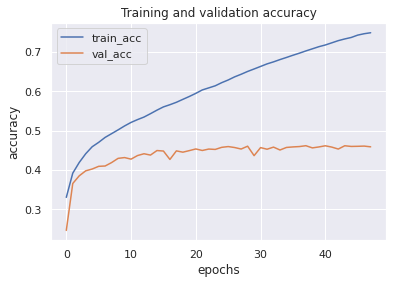

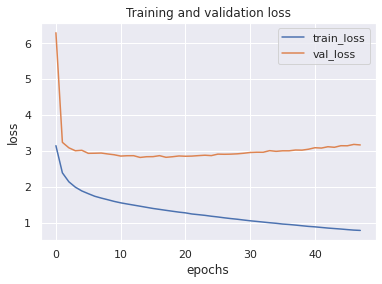

In [ ]:
plot_accuracy_loss(history,run_counter,def_base)

In [ ]:
model=tf.keras.models.load_model(def_base+run_counter+'.h5')

In [ ]:
def Evaluation(model):
  results = model.evaluate([val_X_seqs_final,val_X_ims_final], val_Y_final, batch_size=300)
  print('val loss, val acc:', results)
Evaluation(model)

406/406 [==============================] - 35s 86ms/step - loss: 3.0217 - accuracy: 0.4619
val loss, val acc: [3.0216963291168213, 0.46189677715301514]


In [ ]:
result = []

p = model.predict([val_X_seqs_final,val_X_ims_final],batch_size=256)

for q in range(len(val_q_ids)):
  # if(q<val_size):
  ans=indextoanswer[p[q].argmax(axis=-1)]
  q_id=val_q_ids[q]
  result.append({u'answer': ans, u'question_id': q_id})
  # else:
  #   ans='NAN'
  # q_id=val_q_ids[q]
  # result.append({u'answer': ans, u'question_id': q_id})

  # if q%50000==0 :print(q)

print('Saving result...')
my_list = list(result)
dd = json.dump(my_list,open(BASE_PATH_parssoft2+'result.json','w'))

Saving result...


In [ ]:
# coding: utf-8

import sys
dataDir = '/content/drive/My Drive/parssoftco_PVQA2'
sys.path.insert(0, '/content/drive/My Drive/parssoftco_PVQA/')
from vqaTools.vqa import VQA
from vqaEvaluation.vqaEval import VQAEval
import matplotlib.pyplot as plt
import skimage.io as io
import json
import random
import os

# set up file names and paths
versionType ='' # this should be '' when using VQA v2.0 dataset
taskType    ='OpenEnded' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0. 
dataSubType ='val2014'
annFile     ='%s/%s%s_%s_annotations.json'%(dataDir, versionType, dataType, dataSubType)
quesFile    ='%s/google-val_questions.json'%(dataDir)
imgDir      ='%s/Images/%s/%s/' %(dataDir, dataType, dataSubType)
fileTypes   = ['results', 'accuracy', 'evalQA', 'evalQuesType', 'evalAnsType']

# An example result json file has been provided in './Results' folder.  

[resFile, accuracyFile, evalQAFile, evalQuesTypeFile, evalAnsTypeFile] =['%s/result.json'%(dataDir) for fileType in fileTypes]
# create vqa object and vqaRes object
vqa = VQA(annFile, quesFile)
vqaRes = vqa.loadRes(resFile, quesFile)

# create vqaEval object by taking vqa and vqaRes
vqaEval = VQAEval(vqa, vqaRes, n=2)   #n is precision of accuracy (number of places after decimal), default is 2

# evaluate results
"""
If you have a list of question ids on which you would like to evaluate your results, pass it as a list to below function
By default it uses all the question ids in annotation file
"""
vqaEval.evaluate() 

# print accuracies
print ("\n")
print ("Overall Accuracy is: %.02f\n" %(vqaEval.accuracy['overall']))

print ("Per Answer Type Accuracy is the following:")
for ansType in vqaEval.accuracy['perAnswerType']:
	print ("%s : %.02f" %(ansType, vqaEval.accuracy['perAnswerType'][ansType]))
print ("\n")


loading VQA annotations and questions into memory...
0:00:02.500501
creating index..#.#
index created!
Loading and preparing results...     
DONE (t=0.21s)
creating index..#.#
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 53.37

Per Answer Type Accuracy is the following:
other : 39.89
yes/no : 78.22
number : 33.00


